# 勾配ブースティング決定木のデモプログラム

勾配ブースティング決定木のデモプログラムです。  
勾配ブースティング決定木の中身に関してはこちら↓で解説しています。  
https://yuyumoyuyu.com/2021/02/21/ensembledecisiontree/

ハイパーパラメータの調整にはOptunaを使用しています。  
ローカルで本プログラムを実行する場合は，  
事前にOptunaおよびXBoost,LightGBMのライブラリをダウンロードしておく必要があります。

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.figure as figure
import numpy as np

import time

from sklearn import model_selection, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR

from xgboost import XGBClassifier as XGBC
from xgboost import XGBRegressor as XGBR

from lightgbm import LGBMClassifier as LGBC
from lightgbm import LGBMRegressor as LGBR

import optuna

# クラス分類

In [3]:
from sklearn.datasets import load_iris

In [4]:
# Irisデータセットを用いる
iris = load_iris()

# 初期設定
fold_number = 3  # "k-分割交差検証の分割数
fraction_of_validation_samples = 0.2 # 検証に使うデータ割合

# 学習データをtrain/test分割
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(iris.data,
                                                            iris.target,
                                                            random_state=0)

# スケーリング
scaler_c = StandardScaler()
X_train_i_scaled = scaler_c.fit_transform(X_train_i)
X_test_i_scaled = scaler_c.transform(X_test_i)

# 検証用
X_train_i_tmp, X_valid_i, y_train_i_tmp, y_valid_i = train_test_split(X_train_i_scaled,
                                                                      y_train_i,
                                                                      test_size=fraction_of_validation_samples,
                                                                      random_state=0)

In [ ]:
# scikit-learnの勾配ブースティング
t1 = time.time()

gbc = GBC(n_estimators=1000, 
          validation_fraction=fraction_of_validation_samples,
          n_iter_no_change=100)
gbc.fit(X_train_i_scaled, y_train_i)
best_n_estimators_in_cv = len(gbc.estimators_)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 20),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0)
    }

    gbc = GBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(gbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

gbc = GBC(**study.best_params, 
          n_estimators=1000,
          validation_fraction=fraction_of_validation_samples, 
          n_iter_no_change=100)
gbc.fit(X_train_i_scaled, y_train_i)
best_n_estimators = len(gbc.estimators_)

gbc = GBC(**study.best_params, n_estimators=best_n_estimators)
gbc.fit(X_train_i_scaled, y_train_i)

t2 = time.time()

In [6]:
# scikit-learnの勾配ブースティングの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

elapsed time: 41.114 sec

training samples
[0, 1, 2]
[[37  0  0]
 [ 0 34  0]
 [ 0  0 41]]

test samples
[0, 1, 2]
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


In [ ]:
# XGBoost
t1 = time.time()

xgbc = XGBC(n_estimators=1000)
xgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=[(X_valid_i, y_valid_i)],
         eval_metric='mlogloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = xgbc.best_iteration

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    xgbc = XGBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(xgbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

xgbc = XGBC(**study.best_params, n_estimators=1000)
xgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=[(X_valid_i, y_valid_i.reshape([len(y_valid_i), 1]))],
         eval_metric='mlogloss', 
         early_stopping_rounds=100)
best_n_estimators = xgbc.best_iteration

xgbc = XGBC(**study.best_params, n_estimators=best_n_estimators)
xgbc.fit(X_train_i_scaled, y_train_i)

t2 = time.time()

In [8]:
# XGBoostの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

elapsed time: 17.832 sec

training samples
[0, 1, 2]
[[37  0  0]
 [ 0 34  0]
 [ 0  0 41]]

test samples
[0, 1, 2]
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


In [ ]:
# LightGBM
t1 = time.time()

lgbc = LGBC(n_estimators=1000)
lgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=(X_valid_i, y_valid_i),
         eval_metric='logloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbc.best_iteration_

def objective(trial):
    param = {
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    lgbc = LGBC(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(lgbc, X_train_i_scaled, y_train_i, cv=fold_number)
    acc = metrics.accuracy_score(y_train_i, estimated_y_in_cv)
    return 1.0 - acc

study = optuna.create_study()
study.optimize(objective, n_trials=100)

lgbc = LGBC(**study.best_params, n_estimators=1000)
lgbc.fit(X_train_i_tmp, 
         y_train_i_tmp,
         eval_set=(X_valid_i, y_valid_i),
         eval_metric='logloss', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbc.best_iteration_

lgbc = LGBC(**study.best_params, n_estimators=best_n_estimators)
lgbc.fit(X_train_i_scaled, y_train_i)

t2 = time.time()

In [10]:
# LightGBMの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_i_est = gbc.predict(X_train_i_scaled)

confusion_matrix_train = metrics.confusion_matrix(y_train_i, y_train_i_est, labels=sorted(set(y_train_i)))
print('training samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_train)

# testデータ
y_test_i_pred = gbc.predict(X_test_i_scaled)

confusion_matrix_test = metrics.confusion_matrix(y_test_i, y_test_i_pred, labels=sorted(set(y_train_i)))
print('')
print('test samples')
print(sorted(set(y_train_i)))
print(confusion_matrix_test)

elapsed time: 15.261 sec

training samples
[0, 1, 2]
[[37  0  0]
 [ 0 34  0]
 [ 0  0 41]]

test samples
[0, 1, 2]
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


# 回帰木

In [11]:
from sklearn.datasets import load_boston

In [12]:
# Bostonデータセットを用いる
boston = load_boston()

# 初期設定
fold_number = 3  # "k-分割交差検証の分割数
fraction_of_validation_samples = 0.2 # 検証に使うデータ割合

# 学習データをtrain/test分割
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(boston.data,
                                                            boston.target,
                                                            random_state=0)

# スケーリング
scaler_r = StandardScaler()
X_train_b_scaled = scaler_r.fit_transform(X_train_b)
X_test_b_scaled = scaler_r.transform(X_test_b)

# 検証用
X_train_b_tmp, X_valid_b, y_train_b_tmp, y_valid_b = train_test_split(X_train_b_scaled,
                                                                      y_train_b,
                                                                      test_size=fraction_of_validation_samples,
                                                                      random_state=0)

In [ ]:
# scikit-learnの勾配ブースティング
t1 = time.time()

gbr = GBR(n_estimators=1000, 
          validation_fraction=fraction_of_validation_samples,
          n_iter_no_change=100)
gbr.fit(X_train_b_scaled, y_train_b)
best_n_estimators_in_cv = len(gbr.estimators_)

def objective(trial):
    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 20),
        'max_features': trial.suggest_loguniform('max_features', 0.1, 1.0)
    }

    gbr = GBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(gbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

gbr = GBR(**study.best_params, 
          n_estimators=1000,   
          validation_fraction=fraction_of_validation_samples, 
          n_iter_no_change=100)
gbr.fit(X_train_b_scaled, y_train_b)
best_n_estimators = len(gbr.estimators_)

gbr = GBR(**study.best_params, n_estimators=best_n_estimators)
gbr.fit(X_train_b_scaled, y_train_b)

t2 = time.time()

elapsed time: 34.502 sec



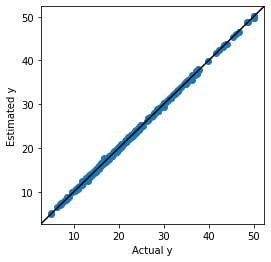

  Training set score: 1.000


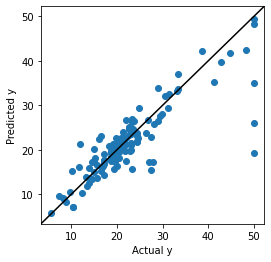

  Test set score: 0.718


In [14]:
# scikit-learnの勾配ブースティングの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_b_est = gbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(gbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = gbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(gbr.score(X_test_b_scaled, y_test_b)))

In [ ]:
# XGBoost
t1 = time.time()

xgbr = XGBR(n_estimators=1000)
xgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=[(X_valid_b, y_valid_b.reshape([len(y_valid_b), 1]))],
         eval_metric='rmse', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = xgbr.best_iteration

def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0)
    }

    if param['booster'] == 'gbtree' or param['booster'] == 'dart':
        param['max_depth'] = trial.suggest_int('max_depth', 1, 9)
        param['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        param['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    if param['booster'] == 'dart':
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)

    xgbr = XGBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(xgbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

xgbr = XGBR(**study.best_params, n_estimators=1000)
xgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=[(X_valid_b, y_valid_b.reshape([len(y_valid_b), 1]))],
         eval_metric='rmse', 
         early_stopping_rounds=100)
best_n_estimators = xgbr.best_iteration

xgbr = XGBR(**study.best_params, n_estimators=best_n_estimators)
xgbr.fit(X_train_b_scaled, y_train_b)

# trainデータ
y_train_b_est = xgbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(xgbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = xgbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(xgbr.score(X_test_b_scaled, y_test_b)))

t2 = time.time()

elapsed time: 13.395 sec



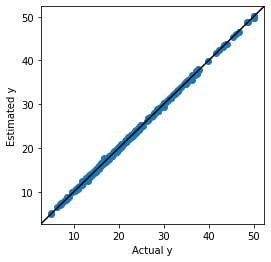

  Training set score: 1.000


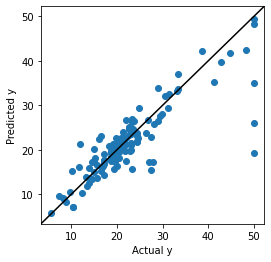

  Test set score: 0.718


In [16]:
# XGBoostの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_b_est = gbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(gbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = gbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(gbr.score(X_test_b_scaled, y_test_b)))

In [ ]:
# LightGBM
t1 = time.time()

lgbr = LGBR(n_estimators=1000)
lgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=(X_valid_b, y_valid_b),
         eval_metric='l2', 
         early_stopping_rounds=100)
best_n_estimators_in_cv = lgbr.best_iteration_

def objective(trial):
    param = {
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0)
    }

    if param['boosting_type'] == 'dart':
        param['drop_rate'] = trial.suggest_loguniform('drop_rate', 1e-8, 1.0)
        param['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    if param['boosting_type'] == 'goss':
        param['top_rate'] = trial.suggest_uniform('top_rate', 0.0, 1.0)
        param['other_rate'] = trial.suggest_uniform('other_rate', 0.0, 1.0 - param['top_rate'])

    lgbr = LGBR(**param, n_estimators=best_n_estimators_in_cv)
    estimated_y_in_cv = model_selection.cross_val_predict(lgbr, X_train_b_scaled, y_train_b, cv=fold_number)
    r2 = metrics.r2_score(y_train_b, estimated_y_in_cv)
    return 1.0 - r2

study = optuna.create_study()
study.optimize(objective, n_trials=100)

lgbr = LGBR(**study.best_params, n_estimators=1000)
lgbr.fit(X_train_b_tmp, 
         y_train_b_tmp,
         eval_set=(X_valid_b, y_valid_b),
         eval_metric='l2', 
         early_stopping_rounds=100)
best_n_estimators = lgbr.best_iteration_

lgbr = LGBR(**study.best_params, n_estimators=best_n_estimators)
lgbr.fit(X_train_b_scaled, y_train_b)

# trainデータ
y_train_b_est = lgbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(lgbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = lgbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(lgbr.score(X_test_b_scaled, y_test_b)))

t2 = time.time()

elapsed time: 46.701 sec



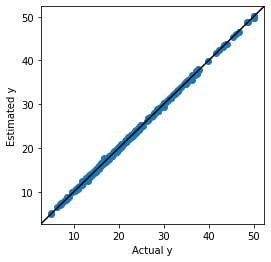

  Training set score: 1.000


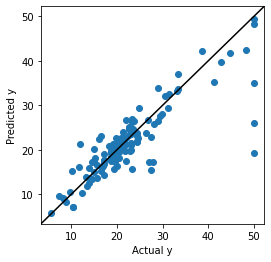

  Test set score: 0.718


In [18]:
# LightGBMの結果
print("elapsed time: {:.3f} sec\n".format(t2-t1))

# trainデータ
y_train_b_est = gbr.predict(X_train_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_train_b, y_train_b_est)
y_max = max( y_train_b.max(), y_train_b_est.max() )
y_min = min( y_train_b.min(), y_train_b_est.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Estimated y')
plt.show()
print("  Training set score: {:.3f}".format(gbr.score(X_train_b_scaled, y_train_b))) 

# testデータ
y_test_b_pred = gbr.predict(X_test_b_scaled)

plt.figure(figsize=figure.figaspect(1))
plt.scatter(y_test_b, y_test_b_pred)
y_max = max( y_test_b.max(), y_test_b_pred.max() )
y_min = min( y_test_b.min(), y_test_b_pred.min() )
plt.plot([y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)],
         [y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min)], 'k-')
plt.ylim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlim(y_min - 0.05 * (y_max - y_min), y_max + 0.05 * (y_max - y_min))
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.show()
print("  Test set score: {:.3f}".format(gbr.score(X_test_b_scaled, y_test_b)))